# 从全连接到局部感知：卷积神经网络（CNN）的革命性突破

在多层感知器（MLP）的时代，神经网络已经展现出强大的非线性拟合能力，但面对图像、语音等高维结构化数据时，MLP 的全连接架构暴露了严重缺陷：

- 参数爆炸：一张 28×28 的灰度图（如MNIST）输入 MLP 需要学习 784×N 个权重（N 为隐藏层大小），计算成本极高。

- 忽略局部关联性：MLP 将像素视为独立特征，无法有效捕捉图像中的空间层次模式（如边缘、纹理、物体部件）。

1968年，神经生理学家David Hubel和Torsten Wiesel发现猫的视觉皮层存在「局部感受野」-- 不同神经元对特定方向的边缘敏感，这一发现启发了后来的卷积操作。

1989年，杨立昆(Yann LeCun)团队首次将卷积结构与反向传播算法结合，在贝尔实验室开发了可用于手写数字识别的 CNN 雏形。

**卷积神经网络（CNN）相比 MLP 核心改进**

1. 局部感受野（Local Receptive Fields）

MLP 的缺陷：每个神经元连接所有输入像素，导致冗余计算。

CNN 的突破：卷积核仅在局部滑动，提取局部特征（如边缘、角点）。

参数共享：同一卷积核在整个图像上复用，大幅减少参数量（如 3×3 卷积核仅需 9 个权重）。

2. 层次化特征提取（Hierarchical Feature Learning）

MLP 的局限：隐藏层特征无明确物理意义。

CNN 的思想：

- 低层卷积：检测基础模式（如梯度、纹理）。
- 高层卷积：组合低层特征，形成高级语义（如眼睛、车轮）。
- 池化层：通过下采样增强平移不变性。

3. 平移不变性（Translation Invariance）

MLP 的问题：物体位置变化会导致完全不同的激活模式。

CNN 的解决方案：

- 卷积核的滑动操作天然支持位置无关的特征检测。
- 池化层进一步模糊位置细节，使网络更关注“是否存在特征”而非“特征在何处”。

# MNIST：深度学习的“Hello World”

1. MNIST 是什么？

Modified National Institute of Standards and Technology database 是一个经典的手写数字识别数据集，由 Yann LeCun 等人于 1990 年代整理并广泛用于机器学习研究。

它包含：

- 训练集：60,000 张 28×28 像素的灰度手写数字（0-9）。

- 测试集：10,000 张同类图像，用于评估模型性能。

每张图片都带有对应的标签（0-9），任务目标是训练模型正确识别这些数字。

2. 为什么是 MNIST？

(1) 简单但非平凡

数据规模小：28×28 的低分辨率图像（共 784 像素），计算资源需求低。

类别清晰：仅 10 类数字，分类任务直观易懂。

非完全线性可分：数字的书写风格多样（如“7”带横线、“4”开口或闭合），需非线性模型才能高精度分类。

(2) 验证模型能力的“试金石”

MLP 基准：单隐层全连接网络可达 ~97% 准确率，但参数量大。

CNN 优势：LeNet-5 等简单卷积网络轻松突破 99%，证明局部感知的高效性。

(3) 标准化的评估环境

学术界已积累大量 MNIST 上的基准结果（如错误率 <0.5% 的模型列表），便于横向对比。

数据已预处理好（归一化、中心化），省去繁琐的数据清洗步骤。

(4) 可视化的绝佳案例

卷积核可直观解释为“边缘检测器”（如某些核响应数字的斜线或曲线）。

错误样本易于人工复核（如混淆“5”和“6”），帮助理解模型局限。

3. MNIST 的局限

尽管 MNIST 是理想的教学工具，但需注意其局限性：

过于简单：现代深度学习模型（如 ResNet、Transformer）在此任务上已接近饱和（>99.5% 准确率）。

与现实数据的差距：真实图像通常具有更高分辨率、多通道（RGB）、复杂背景等。

In [1]:
# 加载 MNIST 数据集
from PIL import Image

def load_mnist_to_tensor():
    from torchvision.datasets import MNIST
    from torchvision.transforms.functional import to_tensor

    train_data = MNIST("", True, download=True)

    train_dataset = [(to_tensor(image), label) for image, label in train_data]

    test_data = MNIST("", False, download=True)

    test_dataset = [(to_tensor(image), label) for image, label in test_data]

    return train_dataset, test_dataset

train_dataset, test_dataset = load_mnist_to_tensor()

In [2]:
import torch
from torch.utils.data import DataLoader
from collections.abc import Callable

@torch.no_grad()
def evaluate(model: torch.nn.Module, tensors: torch.Tensor, labels: torch.Tensor):
    """返回准确率"""
    model.eval()
    outputs = model(tensors)
    pred = torch.argmax(outputs, dim=1)
    accuracy = torch.sum(pred == labels).item() / labels.size(0)
    model.train()
    return accuracy


def train_model(
    model: torch.nn.Module,
    dataloader: DataLoader,
    eval_iters: int = 10,
    learning_rate=0.001,
    evaluate: Callable | None = None,
):
    """模型训练模块"""
    lossi = []
    if evaluate is not None:
        print("initial accuracy:", evaluate())
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(eval_iters):
        for x, y in dataloader:
            output = model(x)
            loss = torch.nn.functional.cross_entropy(output, y)
            lossi.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if evaluate is not None:
            print("epoch", epoch, "accuracy:", evaluate())

    return lossi

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 准备测试数据集
test_tensors = torch.stack([tensor for tensor, _ in test_dataset], dim=0).to(DEVICE)
test_labels = torch.tensor([label for _, label in test_dataset], device=DEVICE)
# 准备数据集
train_dataset = [(x.to(DEVICE), torch.tensor(y, device=DEVICE)) for x, y in train_dataset]

In [4]:
# 使用 MLP
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 256)
        self.fc2 = torch.nn.Linear(256, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
model = MLP().to(DEVICE)

lossi = train_model(
    model,
    DataLoader(train_dataset, batch_size=100, shuffle=True),
    6,
    evaluate=lambda: evaluate(model, test_tensors, test_labels),
)

initial accuracy: 0.0973
epoch 0 accuracy: 0.9528
epoch 1 accuracy: 0.9619
epoch 2 accuracy: 0.9717
epoch 3 accuracy: 0.9754
epoch 4 accuracy: 0.9751
epoch 5 accuracy: 0.9773


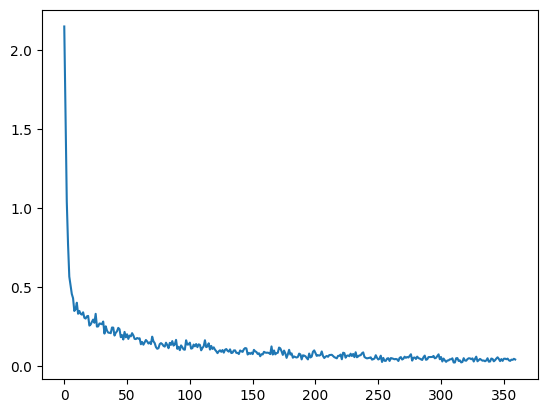

In [6]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi).view(-1, 10).mean(dim=1))
plt.show()

我们已经用 MLP 进行了 MNIST 的训练。进行 6 轮已经达成了 97.5% 的准确率。

# 卷积神经网络架构设计

1. 卷积层（Convolutional Layers）

卷积核大小常用 3×3（小感受野，适合细节特征）或 5×5（大感受野，适合全局模式），更深的网络（如 ResNet）倾向于使用 3×3 堆叠（减少计算量，增加非线性）。

- 步长（Stride）：
  
  Stride=1（默认）：保持空间分辨率，计算量较大。
  
  Stride=2：替代池化层，直接下采样（如 MobileNet）。

- 填充（Padding）：

  "Same" Padding（输入输出尺寸不变，计算量增加）。

  "Valid" Padding（无填充，输出尺寸减小）。

2. 池化层（Pooling Layers）
  
   最大池化（Max Pooling）（更常用）：保留最显著特征，增强平移不变性。

   平均池化（Avg Pooling）：平滑特征，适用于分类任务最后一层（如 ResNet）。

   步长卷积（Strided Conv）：替代池化，可学习下采样（如 VGG）。

   全局平均池化（Global Avg Pooling）：替代全连接层，减少参数（如 SqueezeNet）。

3. 深度与宽度

- 深度（Depth）：

  更深的网络（如 ResNet-50）能学习更复杂特征，但训练难度增加。

  过深可能导致梯度消失（需搭配残差连接）。

- 宽度（Filters 数量）：

  低层：较少通道（如 32-64），检测基础特征（边缘、颜色）。

  高层：更多通道（如 256-512），组合高级语义（物体部件）。


此外，还可以在全连接层前做一些防止过拟合操作，如 dropout 等。

下面会实现一个卷积神经网络

In [7]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # [28,28]
        self.conv1 = torch.nn.Conv2d(1, 16, (5, 5))
        # [24,24]
        self.pool1 = torch.nn.MaxPool2d((2, 2))
        # [12,12]
        self.conv2 = torch.nn.Conv2d(16, 32, (3, 3))
        # [10,10]
        self.pool2 = torch.nn.MaxPool2d((2, 2))
        # [5,5]
        self.fc1 = torch.nn.Linear(32 * 5 * 5, 128)
        self.dp = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.pool2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc1(x.view(batch_size, 32 * 5 * 5))
        x = torch.nn.functional.relu(x)
        x = self.dp(x)
        x = self.fc2(x)
        return x

In [8]:
model = CNN().to(DEVICE)

lossi = train_model(
    model,
    DataLoader(train_dataset, batch_size=100, shuffle=True),
    6,
    evaluate=lambda: evaluate(model, test_tensors, test_labels),
)

initial accuracy: 0.0987
epoch 0 accuracy: 0.9743
epoch 1 accuracy: 0.9834
epoch 2 accuracy: 0.9857
epoch 3 accuracy: 0.9883
epoch 4 accuracy: 0.989
epoch 5 accuracy: 0.9897


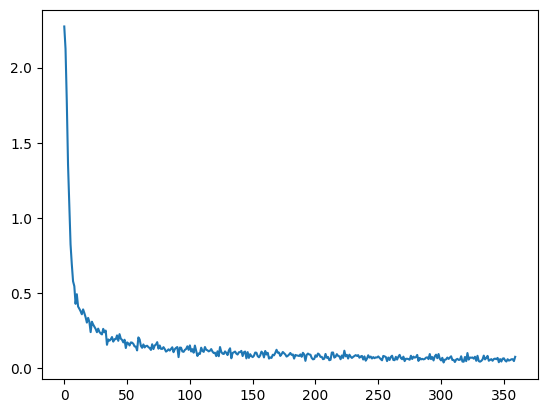

In [9]:
plt.plot(torch.tensor(lossi).view(-1, 10).mean(dim=1))
plt.show()

我们已经用两层卷积的 CNN 进行了 MNIST 的训练。进行 6 轮已经达成了 99% 的准确率。第一轮训练的准确率高于 MLP 6 轮训练

# 残差连接 Residual Connection

在2015年之前，卷积神经网络（CNN）的深度提升遭遇瓶颈：

梯度消失/爆炸问题：反向传播时，梯度在深层网络中指数级衰减或放大，导致底层权重难以更新。

网络退化（Degradation）：实验发现，56层CNN在ImageNet上的表现反而不如20层网络（并非过拟合，而是优化困难）。

核心矛盾：理论上更深的网络应具备更强的表达能力，但实际训练中性能不升反降。

何恺明团队在ResNet（2015）中提出残差学习（Residual Learning）：

基本假设：让网络直接学习“残差”（目标映射与输入之间的差值），而非完整的映射。

数学表达：

传统层：y = F(x)

残差块：y = F(x) + x（F(x)为残差函数，x为跳跃连接（Shortcut Connection））

因为层与层之间有和前面一层直接相加的部分，那么反向传播的梯度流动会更好的保留下去，以至于能让更深的参数得以更新

但是由于跳跃连接是直接相加，所以要保证卷积后大小不变，经典实现是利用3*3大小的卷积块卷积经过 padding = 1 扩张的张量实现的

如果经过池化或改变了线性层大小等操作导致张量大小改变则需要进行卷积核 1*1 的相应步长下采样。

In [10]:
# 代码实战：残差 vs 普通 CNN对比

class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv5 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = torch.relu(self.conv1(x) + residual)
        residual = out
        out = torch.relu(self.conv2(out) + residual)
        residual = out
        out = torch.relu(self.conv3(out) + residual)
        residual = out
        out = torch.relu(self.conv4(out) + residual)
        residual = out
        out = torch.relu(self.conv5(out) + residual)
        return out


class PlainBlock(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv5 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = torch.relu(self.conv2(out))
        out = torch.relu(self.conv3(out))
        out = torch.relu(self.conv4(out))
        out = torch.relu(self.conv5(out))
        return out


# 测试梯度
def check_gradient(model):
    x = torch.randn(1, 64, 32, 32, requires_grad=True)
    y = model(x)
    y.mean().backward()
    assert x.grad is not None
    return x.grad.mean().item()


print(f"普通5层卷积梯度：{check_gradient(PlainBlock(64))}")
print(f"残差5层卷积梯度：{check_gradient(ResidualBlock(64))}")

普通5层卷积梯度：1.7489010240012703e-09
残差5层卷积梯度：1.0920472959696781e-05


残差连接让梯度直接高了好几个数量级。

下面会实现一个残差神经网络

In [11]:
class ResidualBlock(torch.nn.Module):

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, (3, 3), stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, (3, 3), padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        if stride != 1 or in_channels != out_channels:
            self.downsample = torch.nn.Conv2d(in_channels, out_channels, (1, 1), stride=stride)
            self.bn3 = torch.nn.BatchNorm2d(out_channels)
        else:
            self.downsample = None

    def forward(self, x: torch.Tensor):
        if self.downsample:
            res = self.downsample(x)
            res = self.bn3(res)
        else:
            res = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x) + res
        return x


class ResNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.block1 = ResidualBlock(1, 16)
        self.block1_2 = ResidualBlock(16, 16)
        self.block1_3 = ResidualBlock(16, 16)
        # [28,28] -> [14,14]
        self.block2 = ResidualBlock(16, 32, stride=2)
        self.block2_2 = ResidualBlock(32, 32)
        self.block2_3 = ResidualBlock(32, 32)
        # [14,14] -> [7,7]
        self.block3 = ResidualBlock(32, 64, stride=2)
        self.block3_2 = ResidualBlock(64, 64)
        self.block3_3 = ResidualBlock(64, 64)
        # [7,7] -> [5,5]
        self.conv1 = torch.nn.Conv2d(64, 64, (3, 3))
        # [5,5] -> [3,3]
        self.conv2 = torch.nn.Conv2d(64, 64, (3, 3))
        self.fc = torch.nn.Linear(64 * 3 * 3, 10)

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]
        x = self.block1(x)
        x = self.block1_2(x)
        x = self.block1_3(x)
        x = self.block2(x)
        x = self.block2_2(x)
        x = self.block2_3(x)
        x = self.block3(x)
        x = self.block3_2(x)
        x = self.block3_3(x)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        return self.fc(x.view(batch_size, -1))

In [12]:
model = ResNet().to(DEVICE)

lossi = train_model(
    model,
    DataLoader(train_dataset, batch_size=100, shuffle=True),
    6,
    evaluate=lambda: evaluate(model, test_tensors, test_labels),
)

initial accuracy: 0.0991
epoch 0 accuracy: 0.9861
epoch 1 accuracy: 0.9861
epoch 2 accuracy: 0.991
epoch 3 accuracy: 0.9922
epoch 4 accuracy: 0.9929
epoch 5 accuracy: 0.9917


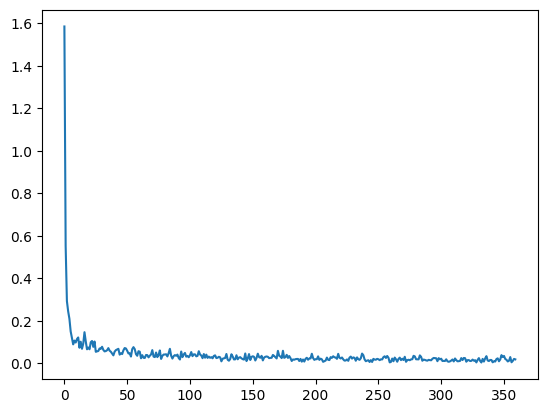

In [13]:
plt.plot(torch.tensor(lossi).view(-1, 10).mean(dim=1))
plt.show()